In [ ]:
!git clone https://github.com/abhinavsagar/Self-Driving-Car.git

Cloning into 'Self-Driving-Car'...
remote: Enumerating objects: 5306, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 5306 (delta 14), reused 0 (delta 0), pack-reused 5282
Receiving objects: 100% (5306/5306), 85.58 MiB | 44.10 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
!ls Self-Driving-Car/IMG

center_2019_07_22_20_38_15_382.jpg  left_2019_07_22_20_41_46_955.jpg
center_2019_07_22_20_38_15_526.jpg  left_2019_07_22_20_41_47_196.jpg
center_2019_07_22_20_38_15_669.jpg  left_2019_07_22_20_41_47_507.jpg
center_2019_07_22_20_38_15_802.jpg  left_2019_07_22_20_41_47_771.jpg
center_2019_07_22_20_38_15_937.jpg  left_2019_07_22_20_41_48_028.jpg
center_2019_07_22_20_38_16_083.jpg  left_2019_07_22_20_41_48_326.jpg
center_2019_07_22_20_38_16_213.jpg  left_2019_07_22_20_41_48_674.jpg
center_2019_07_22_20_38_16_340.jpg  left_2019_07_22_20_41_48_922.jpg
center_2019_07_22_20_38_16_570.jpg  left_2019_07_22_20_41_49_145.jpg
center_2019_07_22_20_38_16_714.jpg  left_2019_07_22_20_41_49_392.jpg
center_2019_07_22_20_38_17_021.jpg  left_2019_07_22_20_41_49_579.jpg
center_2019_07_22_20_38_17_547.jpg  left_2019_07_22_20_41_49_750.jpg
center_2019_07_22_20_38_17_823.jpg  left_2019_07_22_20_41_50_069.jpg
center_2019_07_22_20_38_17_971.jpg  left_2019_07_22_20_41_50_328.jpg
center_2019_07_22_20_38_18_123.jpg

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
## Store data
datadir = 'Self-Driving-Car'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


In [ ]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


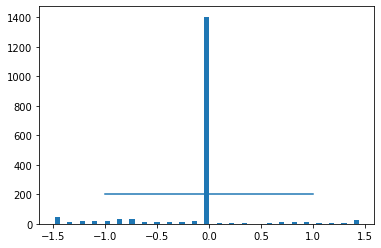

In [ ]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 1743
Removed: 1203
Remaining: 540


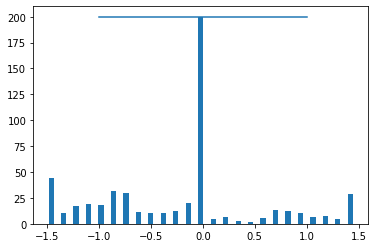

In [ ]:
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

Training Samples: 432
Valid Samples: 108


Text(0.5, 1.0, 'Validation set')

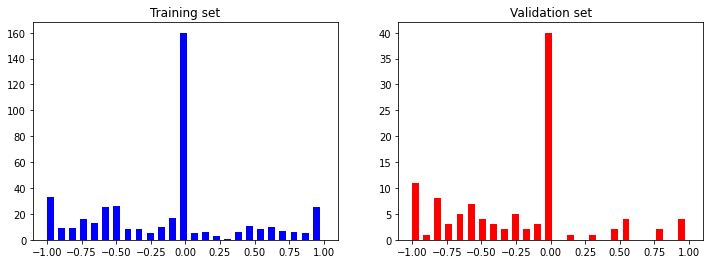

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def img_preprocess(img):
  """Take in path of img, returns preprocessed image"""
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

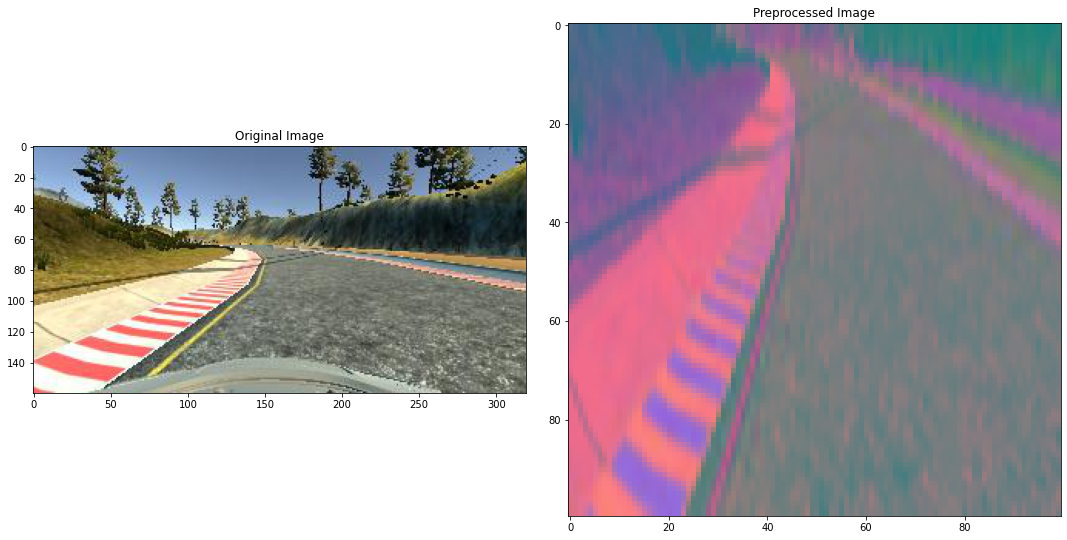

In [ ]:
## Get any image
image = image_paths[10]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

## Compare original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [ ]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(432, 100, 100, 3)


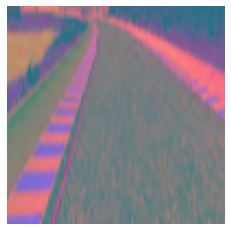

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
from keras.applications import ResNet50
#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ffa61638fd0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7ffa6a85ae10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffa61593ad0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ffa60cf51d0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7ffa52d6a790> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7ffa52d7ff10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ffa50308a10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffa52d8ae10> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ffa60d17e50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7ffa5031a550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffa5031de50> False
<tensorflow.python.keras.laye

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               3276900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

In [ ]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

Epoch 1/25
4/4 [==============================] - 39s 1s/step - loss: 41.0157 - accuracy: 0.2153 - val_loss: 0.6431 - val_accuracy: 0.3704
Epoch 2/25
4/4 [==============================] - 0s 123ms/step - loss: 17.2413 - accuracy: 0.2006 - val_loss: 0.7006 - val_accuracy: 0.3704
Epoch 3/25
4/4 [==============================] - 0s 122ms/step - loss: 5.2575 - accuracy: 0.2454 - val_loss: 0.7123 - val_accuracy: 0.3704
Epoch 4/25
4/4 [==============================] - 0s 121ms/step - loss: 4.3577 - accuracy: 0.2470 - val_loss: 0.4626 - val_accuracy: 0.3704
Epoch 5/25
4/4 [==============================] - 0s 121ms/step - loss: 4.1240 - accuracy: 0.2620 - val_loss: 0.7812 - val_accuracy: 0.0370
Epoch 6/25
4/4 [==============================] - 0s 122ms/step - loss: 3.8697 - accuracy: 0.2375 - val_loss: 0.6846 - val_accuracy: 0.3704
Epoch 7/25
4/4 [==============================] - 0s 122ms/step - loss: 4.7955 - accuracy: 0.2445 - val_loss: 0.5264 - val_accuracy: 0.3704
Epoch 8/25
4/4 [====

Text(0.5, 0, 'Epoch')

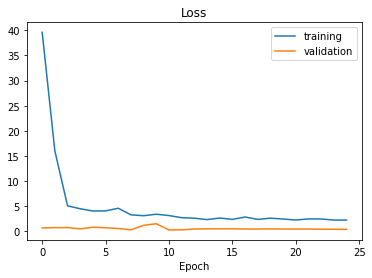

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
import matplotlib.pyplot as plt
data.loc[11]

center      center_2019_07_22_20_38_17_547.jpg
left        left_2019_07_22_20_38_17_547.jpg  
right       right_2019_07_22_20_38_17_547.jpg 
steering   -1                                 
throttle    1                                 
reverse     0                                 
speed       3.59582                           
Name: 11, dtype: object

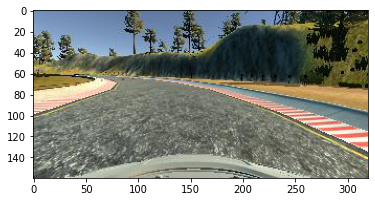

In [ ]:
plt.imshow(npimg.imread('Self-Driving-Car/IMG/center_2019_07_22_20_38_17_547.jpg'))


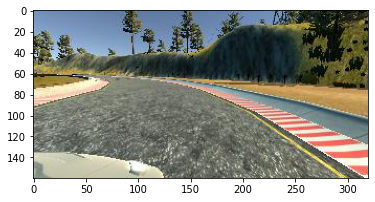

In [ ]:
plt.imshow(npimg.imread('Self-Driving-Car/IMG/right_2019_07_22_20_38_17_547.jpg'))

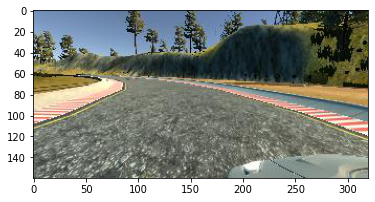

In [ ]:
plt.imshow(npimg.imread('Self-Driving-Car/IMG/left_2019_07_22_20_38_17_547.jpg'))